In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from advectionGP.constraints import equality_constraint
from advectionGP.sensors import FixedSensorModel 
from advectionGP.kernels import meshgridndim
from advectionGP.kernels import EQ 
from advectionGPdatasets.ode_modelsample import ODEModelSample
from advectionGP.models.mesh_1d_ode_model import AdjointSecondOrderODEModel as ODEModel
from scipy.stats import norm
def compute_nlpd(obs_samples,true_vals):
    nlpd = 0
    for idx in range(len(true_vals)):
        ob = np.array(obs_samples)[:,idx]
        nlpd-=norm.logpdf(true_vals[idx],np.mean(ob),np.std(ob))
    return nlpd

#v,plt.hist(ob,7)

#x = np.linspace(-25,35,100)
#plt.plot(x,100*norm.pdf(x,np.mean(ob),np.std(ob)))
#plt.vlines(Y[1::2][4],0,5)

# Generate Results

In [16]:
results = []
for seed in range(30):
    np.random.seed(seed)
    ds = ODEModelSample(non_neg='softplus',k_0=-0.01,u=0.2,eta=0.1,ls=0.5,Npoints=10,shift=-1)
    X, Y, sourceGT, concTrain, boundary, m = ds.X, ds.Y, ds.source, ds.conc, ds.boundary, ds.m

    Nsamples = 100
    record = {}
    ls = 0.5

    N_feat = 500 #Number of features used to infer the source
    k = EQ(ls, 2.0)
    res = [400]
    noiseSD = 0.1
    sensors = FixedSensorModel(X[::2],0.1)

    k_0=-0.01
    u=0.1
    eta=0.1

    mTest = ODEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,k_0=k_0,u=u,eta=eta)
    regressors = mTest.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = mTest.computeZDistribution(Y[::2]) # Infers z vector mean and covariance


    concInferred_samples = []
    sourceInferred_samples = []
    sse_samples = []
    obs_samples = []

    mTest.sensormodel = FixedSensorModel(X[1::2],0.1)
    for jitterA in [0,1e-8,1e-7,1e-6,1e-5,1e-4,None]:
        if jitterA is None:
            break
        try:
            Zsamps = np.random.multivariate_normal(meanZ,covZ+np.eye(len(covZ))*jitterA,Nsamples)
            break
        except np.linalg.LinAlgError:
            print("Failed to invert during Non-negative sampling. Adding jitter...")


    #we just give up with this data point...
    if jitterA is None:
        print("Giving up with this configuration")


    for Z in Zsamps:
        sourceInferred = mTest.computeSourceFromPhi(Z) # Generates estimated source using inferred distributio
        sourceInferred_samples.append(sourceInferred)

        conc = mTest.computeResponse(sourceInferred)
        concInferred_samples.append(conc)
        mTest.conc = conc
        obs = mTest.computeObservations()
        #sse_samples.append(np.sum((obs-Y[1::2])**2))
        sse_samples.append(np.sum((np.mean(np.array(obs),0)-Y[1::2])**2))
        obs_samples.append(obs)
    
    ###Non-neg calculation...
    #################################################################################################
    
    knownS = np.where(sourceGT<0.025)[0]
    newS = np.zeros_like(knownS)

    meanZconstrained, covZconstrained = equality_constraint(mTest,meanZ,covZ,knownS,newS)
    
    for jitterA in [0,1e-8,1e-7,1e-6,1e-5,1e-4,None]:
        if jitterA is None:
            break
        try:
            Zsamps = np.random.multivariate_normal(meanZconstrained,covZconstrained+np.eye(len(covZconstrained))*jitterA,Nsamples)
            break
        except np.linalg.LinAlgError:
            print("Failed to invert during Non-negative sampling. Adding jitter...")
    
    #mTest.sensormodel = FixedSensorModel(X[::2],0.1)
    concInferred_constrained_samples = []
    sourceInferred_constrained_samples = []
    sse_constrained_samples = []
    obs_constrained_samples = []

    mTest.sensormodel = FixedSensorModel(X[1::2],0.1)
    for Z in Zsamps:
        sourceInferred = mTest.computeSourceFromPhi(Z) # Generates estimated source using inferred distributio
        sourceInferred_constrained_samples.append(sourceInferred)

        conc = mTest.computeResponse(sourceInferred)
        concInferred_constrained_samples.append(conc)
        mTest.conc = conc
        obs = mTest.computeObservations()
        #sse_samples.append(np.sum((obs-Y[1::2])**2))
        sse_constrained_samples.append(np.sum((np.mean(np.array(obs),0)-Y[1::2])**2))
        obs_constrained_samples.append(obs)

    
    #record[u]=[mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples]
    rec =[mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_constrained_samples,sourceInferred_constrained_samples,sse_constrained_samples,obs_constrained_samples]
    #pickle.dump(record,open('recordODEfindparams_u_%d_seed=%d.pkl' % (it,seed),'wb'))
    
    sse_constrained = np.sum((np.mean(np.array(obs_constrained_samples),0)-Y[1::2])**2)
    sse_normal = np.sum((np.mean(np.array(obs_samples),0)-Y[1::2])**2)
    
    results.append([sse_normal,sse_constrained, compute_nlpd(obs_samples,Y[1::2]), compute_nlpd(obs_constrained_samples,Y[1::2])])



Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done
Failed to invert during Non-negative sampling. Adding jitter...


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done


Computing SS...
Inverting SS...
Computing meanZ
Done



In [24]:
np.std(np.array(results),0)/np.sqrt(30)

array([7.07884332, 7.96413993, 0.05871365, 0.42251331])

In [25]:
print("sse_normal, sse_constrained, nlpd_normal, nlpd_constrained")
np.mean(np.array(results),0),1.96*np.std(np.array(results),0)/np.sqrt(30)

sse_normal, sse_constrained, nlpd_normal, nlpd_constrained


(array([37.75049309, 36.10025472, 15.83309647, 10.91735044]),
 array([13.87453292, 15.60971427,  0.11507875,  0.82812608]))

95.0


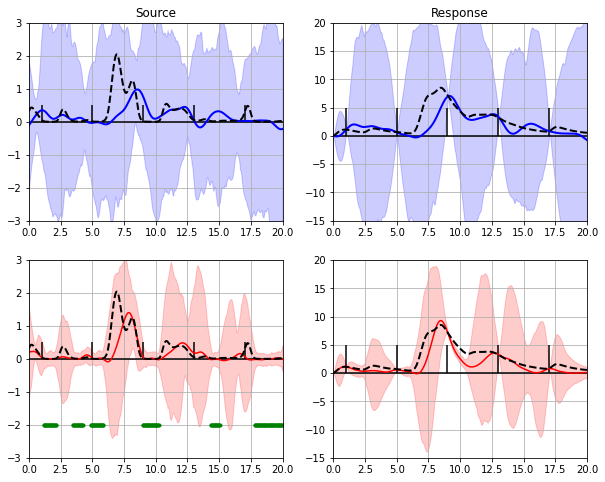

In [14]:
#CIs = [16,84]
CIs = [2.5,97.5]
print(CIs[1]-CIs[0])
plt.figure(figsize=[10,8])
plt.title('Source')
mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples = rec
plt.subplot(2,2,1)

plt.plot(ds.m.coords[0,:],np.mean(sourceInferred_samples,0),'b-',lw=2,label='no constr.')
#plt.plot(ds.m.coords[0,:],np.array(sourceInferred_samples).T,'b-',alpha=0.15)
plt.fill_between(ds.m.coords[0,:],np.percentile(np.array(sourceInferred_samples).T,CIs[0],1),np.percentile(np.array(sourceInferred_samples).T,CIs[1],1),color='blue',alpha=0.2)
plt.plot(ds.m.coords[0,:],sourceGT,'k--',lw=2,label='true')
plt.grid()
#plt.legend()
plt.title('Source')
plt.ylim([-3,3])
plt.hlines(0,-10,100,'k')
plt.xlim([0,20])
plt.vlines(X[::2,0],0,0.5)




plt.subplot(2,2,3)
#plt.text(0,4.5,"u = %0.4f" % v)
#plt.plot(ds.m.coords[0,:],concTrain/100)
plt.plot(ds.m.coords[0,:],np.mean(sourceInferred_nonneg_samples,0),'r-',label='non-neg.')
#plt.plot(ds.m.coords[0,:],np.array(sourceInferred_nonneg_samples).T,'r-',alpha=0.15)
#plt.fill_between(ds.m.coords[0,:],np.min(np.array(sourceInferred_nonneg_samples).T,1),np.max(np.array(sourceInferred_nonneg_samples).T,1),color='red',alpha=0.2)
plt.fill_between(ds.m.coords[0,:],np.percentile(np.array(sourceInferred_nonneg_samples).T,CIs[0],1),np.percentile(np.array(sourceInferred_nonneg_samples).T,CIs[1],1),color='red',alpha=0.2)
plt.plot(ds.m.coords[0,:],sourceGT,'k--',lw=2,label='true')
plt.grid()
#plt.legend()
#plt.title('Source' % u)
plt.vlines(X[::2,0],0,0.5)
plt.ylim([-3,3])
plt.hlines(0,-10,100,'k')
plt.xlim([0,20])
plt.plot(m.coords[0,knownS],newS-2,'.g')



plt.subplot(2,2,2)
plt.plot(ds.m.coords[0,:],np.mean(concInferred_samples,0),'b-',lw=2,label='no constr.')
#plt.plot(ds.m.coords[0,:],np.array(concInferred_samples).T,'b-',alpha=0.15)
plt.plot(ds.m.coords[0,:],concTrain,'k--',lw=2,label='true')
plt.fill_between(ds.m.coords[0,:],np.percentile(np.array(concInferred_samples).T,CIs[0],1),np.percentile(np.array(concInferred_samples).T,CIs[1],1),color='blue',alpha=0.2)
#plt.plot(ds.m.coords[0,:],concTrain/100)
plt.grid()
plt.title('Response')
plt.vlines(X[::2,0],0,5)
plt.ylim([-15,20])
plt.hlines(0,-10,100,'k')
plt.xlim([0,20])



plt.subplot(2,2,4)
plt.plot(ds.m.coords[0,:],np.mean(concInferred_nonneg_samples,0),'r-',label='non-neg.')
#plt.plot(ds.m.coords[0,:],np.array(concInferred_nonneg_samples).T,'r-',alpha=0.15)
plt.plot(ds.m.coords[0,:],concTrain,'k--',lw=2,label='true')
plt.fill_between(ds.m.coords[0,:],np.percentile(np.array(concInferred_nonneg_samples).T,CIs[0],1),np.percentile(np.array(concInferred_nonneg_samples).T,CIs[1],1),color='red',alpha=0.2)
plt.grid()
#plt.legend()
plt.ylim([-15,20])
plt.hlines(0,-10,100,'k')
plt.xlim([0,20])
#plt.title("u = %0.4f" % v)
#plt.title('Response')
plt.vlines(X[::2,0],0,5)

plt.savefig('paper_zero_constraint_helps_a_bit.pdf')  
